In [1]:
import numpy as np
import _pickle as pkl
import torch
%matplotlib inline 
import matplotlib.pyplot as plt
import os, sys, time
sys.path.append('../..')
from utils import set_seed_torch, rgb2gray
set_seed_torch(3)

In [2]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
        
args = ObjectView({'res': 64,
 'dataset_path': '/home/olimoyo/visual-haptic-dynamics/experiments/data/datasets/{}'
                   .format("visual_haptic_2D_len16_withGT_3D9E4376CF4746EEA20DCD520218038D.pkl"),
 'models_dir': '/home/olimoyo/visual-haptic-dynamics/saved_models/{}'
                   .format("vaughan"),
 'device': 'cuda:0',
 'up_to_n_pred': 8,
})

def load_models_dir(models_dir):
    """Load hyperparameters from trained model."""
    dict_of_models = {}
    for filedir in os.listdir(models_dir):
        fullpath = os.path.join(models_dir, filedir)
        if os.path.isdir(fullpath):
            with open(os.path.join(fullpath, 'hyperparameters.txt'), 'r') as fp:
                dict_of_models[fullpath] = Namespace(**json.load(fp))
    return dict_of_models

In [3]:
with open(args.dataset_path, 'rb') as f:
    raw_data = pkl.load(f)

data = {}
data['img_rgb'] = torch.from_numpy(raw_data["img"].transpose(0, 1, 4, 2, 3)).int().to(device=args.device)
data['img_gray'] = torch.from_numpy(rgb2gray(raw_data["img"]).transpose(0, 1, 4, 2, 3)).float().to(device=args.device)
data['haptic'] = torch.from_numpy(raw_data['ft']).float().to(device=args.device)
data['arm'] = torch.from_numpy(raw_data['arm']).float().to(device=args.device)
    
actions = torch.from_numpy(raw_data["action"]).to(device=args.device).float()

In [4]:
from utils import load_vh_models, frame_stack
from argparse import Namespace
import json
import torch.nn as nn
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [7]:
dict_of_models = load_models_dir(args.models_dir)
analysis_data = {}

with torch.no_grad():
    for path, model_args in dict_of_models.items():
        
        #XXX: For testing
        if path != '/home/olimoyo/visual-haptic-dynamics/saved_models/vaughan/gru_lm_v_ctex-img':
            continue
        
        model_name = path.split("/")[-1]
        nets = load_vh_models(path=path, args=model_args, mode='eval', device=args.device)

        def encode(nets, x_img, x_ft, x_arm, ctx_img):
            # Prepare context data depending on model
            if model_args.context_modality != "none":
                if model_args.context_modality == "joint": 
                    ctx = torch.cat((x_ft, x_arm), dim=-1) # (n, l, f, 12)
                elif model_args.context_modality == "ft": 
                    ctx = x_ft
                elif model_args.context_modality == "arm":
                    ctx = x_arm
                ctx = ctx.float().to(device=args.device) # (n, l, f, 6)
                ctx = ctx.transpose(-1, -2)
                ctx = ctx.reshape(-1, *ctx.shape[2:])  
                    
            # Encode
            z_all_enc = []

            z_img = nets["img_enc"](x_img)
            z_all_enc.append(z_img)              
            
            context = {}
            if model_args.context_modality != "none":
                z_context = nets["context_enc"](ctx)
                z_all_enc.append(z_context)
                context["z_context"] = z_context
            if model_args.use_context_img:
                z_img_context = nets["context_img_enc"](ctx_img)
                z_all_enc.append(z_img_context)
                context["z_img_context"] = z_img_context

            # Concatenate modalities and mix
            z_cat_enc = torch.cat(z_all_enc, dim=1)
            z, mu_z, logvar_z = nets["mix"](z_cat_enc)
            var_z = torch.diag_embed(torch.exp(logvar_z))
            return z, mu_z, var_z, context
        
        if model_args.dim_x[0] == 1:
            imgs = data['img_gray']
        elif model_args.dim_x[0] == 3:
            imgs = data['img_rgb']
        
        total_len = imgs.shape[1]
        T = model_args.frame_stacks

        analysis_data[model_name] = {}
        for n_pred in range(1, args.up_to_n_pred + 1):
            analysis_data[model_name][f"{n_pred}_pred"] = {}
            analysis_data[model_name][f"{n_pred}_pred"]["MSE_x"] = 0
            analysis_data[model_name][f"{n_pred}_pred"]["MSE_z"] = 0
            analysis_data[model_name][f"{n_pred}_pred"]["SSIM"] = 0
            analysis_data[model_name][f"{n_pred}_pred"]["PSNR"] = 0

            for ii in range(T, total_len - n_pred):
                x_img_i = imgs[:, (ii - 1):(ii + 1)] 
                x_img_i = frame_stack(x_img_i, frames=T)[:, 0]

                x_img_gt = imgs[:, (ii + n_pred - 1):(ii + n_pred + 1)]
                x_img_gt = frame_stack(x_img_gt, frames=T)[:, 0]
                
                if model_args.use_context_img:
                    ctx_img = x_img_i  
                else:
                    ctx_img = None
                
                x_ft_i = data['haptic'][:, ii:(ii + 1)]
                x_ft_gt = data['haptic'][:, (ii + n_pred):(ii + n_pred + 1)]

                x_arm_i = data['arm'][:, ii:(ii + 1)]                 
                x_arm_gt = data['arm'][:, (ii + n_pred):(ii + n_pred + 1)]
 
                z_gt, mu_z_gt, var_z_gt, _ = encode(nets, x_img_gt, x_ft_gt, x_arm_gt, ctx_img)
                print("GT z", z_gt[0])
                print("GT mu", mu_z_gt[0])
                print("GT var", torch.diagonal(var_z_gt[0]))

                u = actions[:, (ii + 1):(ii + n_pred + 1)]
                    
                # Encode
                z_i, mu_z_i, var_z_i, context = encode(nets, x_img_i, x_ft_i, x_arm_i, ctx_img)
                h_i = None
                
                # Predict
                for jj in range(n_pred):
                    z_ip1, mu_z_ip1, var_z_ip1, h_ip1 = nets["dyn"](
                        z_t=z_i, 
                        mu_t=mu_z_i, 
                        var_t=var_z_i, 
                        u=u[:, jj], 
                        h_0=h_i, 
                        single=True
                    )
                    z_i, mu_z_i, var_z_i, h_i = z_ip1, mu_z_ip1, var_z_ip1, h_ip1    
                
                print("PRED z", z_ip1[0])
                print("PRED mu", mu_z_ip1[0])
                print("PRED var", torch.diagonal(var_z_ip1[0]))

                # Decode 
                z_all_dec = []
                z_hat = z_ip1
                z_all_dec.append(z_hat)
                
                if model_args.context_modality != "none":
                    z_all_dec.append(context["z_context"])
                if model_args.use_context_img:
                    z_all_dec.append(context["z_img_context"])
    
                z_cat_dec = torch.cat(z_all_dec, dim=1)
                x_hat = nets["img_dec"](z_cat_dec)

                x_hat = x_hat[:, 0:1].view(x_hat.shape[0], -1).cpu().numpy()
                x_img_gt = x_img_gt[:, 0:1].view(x_img_gt.shape[0], -1).cpu().numpy()
                z_hat = z_hat.cpu().numpy()
                z_gt = z_gt.cpu().numpy()

                n = x_img_gt.shape[0]

                print("prediction length", n_pred, "starting position", ii,
                    "mse img: ", (np.sum((x_img_gt - x_hat)**2) / n),
                    "mse z: ", (np.sum((z_gt - z_hat)**2) / n))
                print()

                analysis_data[model_name][f"{n_pred}_pred"]["MSE_x"] += (np.sum((x_img_gt - x_hat)**2) / n)
                analysis_data[model_name][f"{n_pred}_pred"]["MSE_z"] += (np.sum((z_gt - z_hat)**2) / n)

                batch_ssim = 0
                batch_psnr = 0
                for jj in range(n):
                    batch_ssim += ssim(
                        x_img_gt[jj].reshape(64,64), 
                        x_hat[jj].reshape(64,64), 
                        data_range=1.0
                    )
                    analysis_data[model_name][f"{n_pred}_pred"]["PSNR"] += psnr(
                        x_img_gt[jj].reshape(64,64), 
                        x_hat[jj].reshape(64,64), 
                        data_range=1.0
                    )
                    
                analysis_data[model_name][f"{n_pred}_pred"]["SSIM"] += (batch_ssim / n)
                analysis_data[model_name][f"{n_pred}_pred"]["PSNR"] += (batch_psnr / n)
    
            # Average MSE/SSIM/PSNR per image 
            for k in analysis_data[model_name][f"{n_pred}_pred"]:
                analysis_data[model_name][f"{n_pred}_pred"][k] /= (total_len - n_pred - 1)
    print("DONE!")

Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/vaughan/gru_lm_v_ctex-img
GT z tensor([-0.4293, -0.5053, -0.4585,  0.6210,  3.2412, -0.7455,  0.9202, -0.8953,
        -1.2813,  0.1358, -1.2201,  0.1561,  0.4254,  2.2608, -1.6482,  1.8264],
       device='cuda:0')
GT mu tensor([-0.0034, -0.0065,  0.0055,  0.0075,  3.1247, -0.1103, -0.0131, -0.0069,
         0.0167,  0.0043,  0.0075,  0.0083, -0.0080, -0.0199,  0.0128,  1.9696],
       device='cuda:0')
var tensor([1.3153, 1.3170, 1.2889, 1.2596, 0.0341, 1.6469, 1.3099, 1.3363, 1.2866,
        1.2974, 1.3926, 1.3795, 1.3260, 1.3920, 1.3174, 0.0197],
       device='cuda:0')
PRED z tensor([ 6.2957e-03,  1.2491e-03,  3.3602e-03,  1.5519e-03,  1.5267e+00,
        -2.8483e-01,  4.5838e-03, -1.1171e-03,  7.1727e-03,  1.4958e-02,
         2.9549e-03,  2.0090e-03, -3.8108e-03, -4.0733e-03, -3.1421e-03,
         2.0278e+00], device='cuda:0')
PRED mu tensor([ 6.2957e-03,  1.2491e-03,  3.3602e-03,  1.5519e-03,  1.5267e+00,

prediction length 1 starting position 6 mse img:  2.8174066162109375 mse z:  0.4861182403564453

GT z tensor([-0.1542,  0.0547,  0.1208,  0.0114, -0.3299, -0.0862,  0.0390, -0.1101,
         0.1216, -0.1410, -0.0031,  0.1153, -0.0771, -0.0208, -0.1355,  1.4012],
       device='cuda:0')
GT mu tensor([-1.5415e-03, -5.6520e-04,  5.9475e-03,  1.0900e-03, -3.1561e-01,
        -2.1821e-01,  1.9093e-03, -3.6257e-03,  3.0546e-03,  1.3258e-02,
        -1.3837e-04,  4.1850e-03,  4.4452e-04, -6.1314e-04,  4.7654e-03,
         1.3330e+00], device='cuda:0')
var tensor([0.0115, 0.0113, 0.0113, 0.0111, 0.0047, 0.0097, 0.0115, 0.0114, 0.0112,
        0.0112, 0.0112, 0.0115, 0.0115, 0.0114, 0.0113, 0.0091],
       device='cuda:0')
PRED z tensor([ 1.9491e-03, -1.8644e-03,  1.1753e-03, -3.6770e-04,  4.9355e-01,
        -2.3899e-01,  6.2694e-03, -1.1707e-03,  1.7155e-03,  8.5980e-03,
        -9.7063e-04, -1.6691e-03,  3.3570e-05, -2.3491e-03,  6.3346e-04,
         1.3894e+00], device='cuda:0')
PRED mu ten

prediction length 1 starting position 12 mse img:  19.801263427734376 mse z:  14.17523681640625

GT z tensor([-0.0368, -0.0654,  0.2006, -0.2268, -3.5588,  0.1355,  0.1468,  0.0227,
        -0.1210, -0.0565,  0.0055,  0.0317, -0.1148, -0.0612, -0.0731, -2.3799],
       device='cuda:0')
GT mu tensor([-8.2727e-04,  3.6565e-03, -6.9032e-04, -9.8149e-03, -3.4556e+00,
         9.3584e-02,  1.1782e-02,  2.4483e-03, -8.2000e-03,  5.9663e-03,
        -4.4842e-03,  4.2072e-03,  5.4885e-03,  6.0376e-03,  7.0291e-03,
        -2.4407e+00], device='cuda:0')
var tensor([0.0183, 0.0179, 0.0179, 0.0177, 0.0093, 0.0182, 0.0179, 0.0182, 0.0178,
        0.0182, 0.0179, 0.0180, 0.0179, 0.0177, 0.0177, 0.0060],
       device='cuda:0')
PRED z tensor([ 2.7188e-03,  1.0031e-03, -5.4322e-03, -9.0589e-03, -1.9742e+00,
         1.0561e-01,  1.0100e-02,  3.0653e-03, -3.0411e-03,  3.2871e-03,
         1.2700e-03,  7.1247e-03,  6.5013e-03,  3.1690e-04,  1.7109e-03,
        -2.5008e+00], device='cuda:0')
PRED mu ten

prediction length 2 starting position 4 mse img:  8.352180786132813 mse z:  2.0958311462402346

GT z tensor([-0.1745, -0.1731, -0.1350,  0.0044,  0.3411, -0.1865, -0.3110, -0.3247,
         0.2083,  0.0078,  0.0505, -0.1507,  0.1781, -0.0879, -0.1271,  1.3719],
       device='cuda:0')
GT mu tensor([-1.3269e-03, -1.2684e-03,  6.9324e-03,  3.4673e-03,  5.1682e-01,
        -2.0951e-01, -1.0099e-03, -3.4643e-03,  8.3366e-03,  1.3669e-02,
         1.0952e-03,  5.4107e-03, -1.7168e-03, -7.7436e-04,  6.4319e-03,
         1.2934e+00], device='cuda:0')
var tensor([0.0200, 0.0196, 0.0197, 0.0190, 0.0054, 0.0138, 0.0198, 0.0198, 0.0197,
        0.0194, 0.0193, 0.0200, 0.0203, 0.0198, 0.0193, 0.0098],
       device='cuda:0')
PRED z tensor([ 1.8424e-03, -1.7028e-03,  1.6088e-03,  7.2621e-04,  6.7583e-01,
        -2.8941e-01,  5.1449e-03, -2.3401e-03,  2.1362e-03,  8.6499e-03,
        -1.2442e-03, -1.5564e-03, -1.3038e-03, -2.1739e-03,  5.9401e-04,
         1.7002e+00], device='cuda:0')
PRED mu tens

prediction length 2 starting position 10 mse img:  15.75640625 mse z:  1.6847250366210937

GT z tensor([ 0.0249, -0.0251, -0.1778, -0.0359, -3.2942, -0.0061,  0.0584, -0.1556,
         0.0458, -0.0472,  0.0266,  0.1354, -0.2622, -0.1556,  0.1479, -1.7413],
       device='cuda:0')
GT mu tensor([-2.0660e-03,  2.6976e-03,  1.3778e-03, -8.7634e-03, -3.3407e+00,
         8.3058e-02,  1.2003e-02,  3.4441e-03, -9.5201e-03,  7.5706e-03,
        -4.6313e-03,  5.5580e-03,  8.6366e-03,  4.9782e-03,  2.9801e-03,
        -1.6539e+00], device='cuda:0')
var tensor([0.0121, 0.0118, 0.0118, 0.0118, 0.0099, 0.0098, 0.0119, 0.0120, 0.0118,
        0.0119, 0.0119, 0.0120, 0.0119, 0.0119, 0.0120, 0.0053],
       device='cuda:0')
PRED z tensor([ 1.6323e-04,  1.4035e-04, -4.7492e-03, -8.9196e-03, -1.9470e+00,
         1.3305e-01,  1.0262e-02,  3.9158e-03, -4.0396e-03,  7.1114e-03,
         1.3232e-03,  8.2807e-03,  7.4263e-03, -9.5353e-04,  1.0700e-03,
        -2.3757e+00], device='cuda:0')
PRED mu tensor([ 

prediction length 3 starting position 3 mse img:  10.21166748046875 mse z:  2.5339614868164064

GT z tensor([ 0.1259,  0.0449,  0.1023,  0.1308,  0.4704, -0.4420,  0.0506, -0.0409,
         0.0752, -0.0562,  0.0846,  0.0895, -0.0043, -0.0239, -0.2341,  1.4285],
       device='cuda:0')
GT mu tensor([-1.5445e-03, -1.4815e-03,  6.8870e-03,  3.2387e-03,  4.4721e-01,
        -2.0892e-01, -1.4561e-03, -3.0451e-03,  8.4443e-03,  1.3018e-02,
         1.0865e-03,  5.0619e-03, -1.9529e-03, -8.7297e-04,  7.3368e-03,
         1.2871e+00], device='cuda:0')
var tensor([0.0172, 0.0169, 0.0170, 0.0164, 0.0050, 0.0114, 0.0170, 0.0171, 0.0169,
        0.0168, 0.0166, 0.0172, 0.0175, 0.0171, 0.0166, 0.0092],
       device='cuda:0')
PRED z tensor([-2.0759e-04, -1.7185e-03,  2.4530e-03,  5.5444e-04, -1.6384e-01,
        -2.1578e-01,  4.0349e-03, -1.1855e-03, -1.9510e-04,  6.8542e-03,
        -2.6010e-03, -1.5621e-03, -1.2380e-03, -6.2057e-04, -9.1335e-05,
         1.5889e+00], device='cuda:0')
PRED mu tens

prediction length 3 starting position 9 mse img:  12.810262451171875 mse z:  1.6974185180664063

GT z tensor([ 1.0477e-01,  4.5706e-02,  1.9623e-01,  2.9837e-03, -2.9983e+00,
        -7.1721e-02, -7.5559e-02, -4.7943e-02,  2.4580e-01,  2.5301e-02,
        -3.8144e-02,  9.9009e-02, -9.5432e-02,  1.6002e-02,  7.0787e-02,
        -1.9307e+00], device='cuda:0')
GT mu tensor([-1.9678e-03,  2.9384e-03,  4.7287e-04, -9.4188e-03, -2.9487e+00,
         1.3614e-01,  1.1956e-02,  3.1917e-03, -6.4841e-03,  1.0790e-02,
        -3.0767e-03,  6.9910e-03,  9.8915e-03,  2.2907e-03,  3.3070e-03,
        -2.1205e+00], device='cuda:0')
var tensor([0.0109, 0.0107, 0.0106, 0.0107, 0.0102, 0.0091, 0.0107, 0.0109, 0.0106,
        0.0107, 0.0107, 0.0108, 0.0108, 0.0107, 0.0108, 0.0054],
       device='cuda:0')
PRED z tensor([ 1.4558e-03, -5.1671e-04, -6.2627e-03, -1.0438e-02, -1.3778e+00,
         2.1182e-01,  9.5501e-03,  2.9594e-03, -1.2460e-03,  9.9074e-03,
         2.5303e-03,  1.0521e-02,  7.0698e-03, -4.

prediction length 4 starting position 3 mse img:  12.621845703125 mse z:  3.9749771118164063

GT z tensor([-0.0086,  0.1243,  0.0538, -0.0304, -0.7133, -0.0784,  0.0890,  0.0161,
         0.0841, -0.0685, -0.0251, -0.0893,  0.1043, -0.0973,  0.0881,  1.1413],
       device='cuda:0')
GT mu tensor([-4.3564e-03, -5.6351e-04,  7.6187e-03,  1.4887e-03, -4.5943e-01,
        -1.3325e-01, -1.2676e-03, -2.4265e-03,  3.9006e-03,  1.0441e-02,
         1.9278e-05,  3.1006e-03, -4.3933e-04, -2.2327e-04,  6.8712e-03,
         1.1392e+00], device='cuda:0')
var tensor([0.0073, 0.0072, 0.0072, 0.0071, 0.0046, 0.0049, 0.0072, 0.0072, 0.0071,
        0.0071, 0.0071, 0.0073, 0.0073, 0.0073, 0.0071, 0.0081],
       device='cuda:0')
PRED z tensor([-2.1351e-03, -2.0019e-03,  3.6847e-03, -8.9965e-04, -1.0654e+00,
        -1.6500e-01,  4.4537e-03,  4.7363e-04, -2.5113e-03,  6.6548e-03,
        -3.8765e-03, -6.7055e-04, -8.2639e-06,  1.5882e-03, -6.1618e-04,
         1.4180e+00], device='cuda:0')
PRED mu tensor

prediction length 4 starting position 9 mse img:  14.526143798828125 mse z:  2.226112976074219

GT z tensor([-0.1460, -0.0616,  0.0505,  0.0246, -2.1974,  0.3013,  0.0476, -0.0697,
        -0.0830,  0.1348, -0.1537,  0.0704, -0.0294, -0.0429, -0.1530, -3.0441],
       device='cuda:0')
GT mu tensor([-1.0569e-03,  2.3167e-03, -2.1444e-03, -1.2547e-02, -2.1732e+00,
         2.1577e-01,  1.2765e-02,  3.7788e-03, -1.8276e-03,  1.4088e-02,
        -3.0885e-05,  1.1219e-02,  9.1546e-03,  1.9709e-03,  2.5613e-03,
        -3.1478e+00], device='cuda:0')
var tensor([0.0112, 0.0110, 0.0110, 0.0109, 0.0082, 0.0109, 0.0110, 0.0113, 0.0110,
        0.0111, 0.0110, 0.0112, 0.0113, 0.0111, 0.0110, 0.0067],
       device='cuda:0')
PRED z tensor([ 4.9582e-03, -1.1386e-03, -7.5782e-03, -1.0702e-02,  4.9450e-02,
         2.8282e-01,  7.2358e-03,  4.6675e-04,  4.8341e-03,  1.2841e-02,
         4.8441e-03,  1.2903e-02,  4.7067e-03, -8.6215e-03,  3.2294e-04,
        -3.5200e+00], device='cuda:0')
PRED mu tens

prediction length 5 starting position 4 mse img:  19.377080078125 mse z:  7.763718872070313

GT z tensor([-0.0735,  0.0803,  0.0845,  0.1808, -2.2111,  0.0663,  0.0106, -0.0408,
        -0.1139, -0.0675, -0.0288,  0.0728,  0.1287,  0.1002,  0.0915,  0.3876],
       device='cuda:0')
GT mu tensor([-5.7045e-03,  1.3575e-03,  7.7180e-03, -2.8008e-03, -2.2940e+00,
         4.6310e-02,  2.0999e-03,  6.8098e-04, -3.7393e-03,  7.6531e-03,
        -3.5284e-03,  2.7892e-03,  6.1318e-03,  3.1214e-03,  6.3674e-03,
         1.6723e-01], device='cuda:0')
var tensor([0.0103, 0.0101, 0.0102, 0.0102, 0.0074, 0.0062, 0.0104, 0.0103, 0.0100,
        0.0102, 0.0101, 0.0102, 0.0102, 0.0104, 0.0103, 0.0056],
       device='cuda:0')
PRED z tensor([-3.7444e-03, -1.2231e-03,  4.4152e-03, -3.3660e-03, -1.9040e+00,
        -1.0028e-01,  5.5111e-03,  1.0986e-03, -5.1804e-03,  6.8842e-03,
        -4.3185e-03,  8.4535e-04,  2.3597e-03,  2.9865e-03, -6.3829e-04,
         1.0876e+00], device='cuda:0')
PRED mu tensor(

prediction length 5 starting position 10 mse img:  25.97763427734375 mse z:  4.212442626953125

GT z tensor([ 0.0158, -0.0801,  0.0786, -0.0403,  0.3711, -0.1923,  0.1127, -0.1448,
        -0.0987, -0.0265,  0.0532,  0.0246,  0.2024, -0.0599,  0.0650,  1.2762],
       device='cuda:0')
GT mu tensor([-1.6045e-03, -1.9118e-03,  7.1140e-03,  2.9794e-03,  3.4673e-01,
        -2.0796e-01, -2.0669e-03, -2.4717e-03,  8.4218e-03,  1.2306e-02,
         1.0087e-03,  4.7545e-03, -2.1471e-03, -8.2849e-04,  7.9483e-03,
         1.3047e+00], device='cuda:0')
var tensor([0.0168, 0.0166, 0.0166, 0.0162, 0.0052, 0.0109, 0.0167, 0.0167, 0.0166,
        0.0164, 0.0162, 0.0169, 0.0171, 0.0167, 0.0162, 0.0091],
       device='cuda:0')
PRED z tensor([-4.7242e-03,  9.1952e-06,  2.4114e-03, -7.6692e-03, -2.9736e+00,
         5.9158e-02,  8.2894e-03,  2.9058e-03, -9.0056e-03,  7.2166e-03,
        -3.5524e-03,  4.1264e-03,  6.6317e-03,  3.0742e-03, -4.8241e-04,
        -6.7800e-02], device='cuda:0')
PRED mu tens

prediction length 6 starting position 6 mse img:  15.300928955078126 mse z:  3.377225646972656

GT z tensor([-8.1433e-02, -5.5874e-02, -1.0307e-01, -1.0216e-01, -2.3043e+00,
         3.7901e-01,  1.0781e-01, -1.0622e-01, -1.0592e-01, -4.6745e-02,
        -1.3499e-01,  4.9971e-02,  2.0449e-03, -5.7742e-02,  1.7957e-01,
        -2.8421e+00], device='cuda:0')
GT mu tensor([-9.1636e-04,  3.6542e-03, -2.0516e-03, -1.1795e-02, -2.3915e+00,
         2.8209e-01,  1.0768e-02,  4.6069e-03, -2.5179e-03,  1.4946e-02,
        -7.4872e-04,  9.0511e-03,  1.2143e-02, -1.8443e-04,  3.0276e-03,
        -2.9300e+00], device='cuda:0')
var tensor([0.0124, 0.0121, 0.0122, 0.0122, 0.0100, 0.0100, 0.0123, 0.0125, 0.0120,
        0.0122, 0.0123, 0.0125, 0.0124, 0.0123, 0.0122, 0.0056],
       device='cuda:0')
PRED z tensor([-3.4777e-03, -8.1148e-04,  2.9659e-03, -5.4482e-03, -2.2350e+00,
         1.2082e-02,  5.9917e-03,  1.0437e-03, -5.8462e-03,  7.5269e-03,
        -3.6490e-03,  3.2046e-03,  4.3966e-03,  2.0

prediction length 7 starting position 3 mse img:  24.40345703125 mse z:  8.6264697265625

GT z tensor([ 8.0578e-02,  6.5550e-02, -4.9083e-03, -3.1675e-02, -2.9177e+00,
         5.8358e-02, -3.5308e-02,  1.8091e-02, -9.0981e-02,  4.5525e-03,
        -1.9500e-01, -2.0783e-03,  5.2269e-03,  1.5240e-02, -5.5149e-02,
        -9.3558e-01], device='cuda:0')
GT mu tensor([-4.1816e-03,  1.7605e-03,  5.2841e-03, -5.4159e-03, -2.8667e+00,
         1.4469e-01,  4.5584e-03,  2.7032e-03, -5.8162e-03,  7.6477e-03,
        -5.1011e-03,  4.0405e-03,  9.2253e-03,  3.6300e-03,  5.0570e-03,
        -8.5465e-01], device='cuda:0')
var tensor([0.0100, 0.0097, 0.0097, 0.0099, 0.0073, 0.0060, 0.0098, 0.0099, 0.0096,
        0.0099, 0.0097, 0.0098, 0.0098, 0.0099, 0.0098, 0.0044],
       device='cuda:0')
PRED z tensor([-4.4641e-03,  2.2801e-04,  5.1343e-05, -1.0124e-02, -3.3128e+00,
         1.4225e-01,  9.5941e-03,  3.7324e-03, -9.8220e-03,  7.8828e-03,
        -2.7167e-03,  6.2975e-03,  8.5607e-03,  2.1169e-0

prediction length 8 starting position 1 mse img:  19.852249755859376 mse z:  5.337726440429687

GT z tensor([-0.0088, -0.2344, -0.0078,  0.0135, -2.4020,  0.0524,  0.0030,  0.0409,
        -0.0805, -0.0633,  0.1368, -0.0273, -0.1194, -0.0850,  0.0883,  0.2270],
       device='cuda:0')
GT mu tensor([-6.2689e-03,  4.5257e-04,  7.8521e-03, -2.5444e-03, -2.3799e+00,
         7.3363e-03,  1.3216e-03,  8.2333e-04, -4.1713e-03,  6.2180e-03,
        -3.9510e-03,  2.0131e-03,  6.0911e-03,  3.3759e-03,  7.5392e-03,
         2.1643e-01], device='cuda:0')
var tensor([0.0101, 0.0098, 0.0099, 0.0100, 0.0068, 0.0058, 0.0101, 0.0099, 0.0097,
        0.0100, 0.0098, 0.0099, 0.0099, 0.0101, 0.0100, 0.0057],
       device='cuda:0')
PRED z tensor([-2.5795e-03, -2.4298e-05, -3.9288e-03, -1.2500e-02, -3.1809e+00,
         2.3530e-01,  1.0864e-02,  4.9657e-03, -8.5289e-03,  9.4075e-03,
        -1.0265e-03,  9.1303e-03,  1.0204e-02, -4.6766e-04,  2.7347e-04,
        -2.2445e+00], device='cuda:0')
PRED mu tens

prediction length 8 starting position 7 mse img:  8.948276977539063 mse z:  1.8733830261230469

DONE!


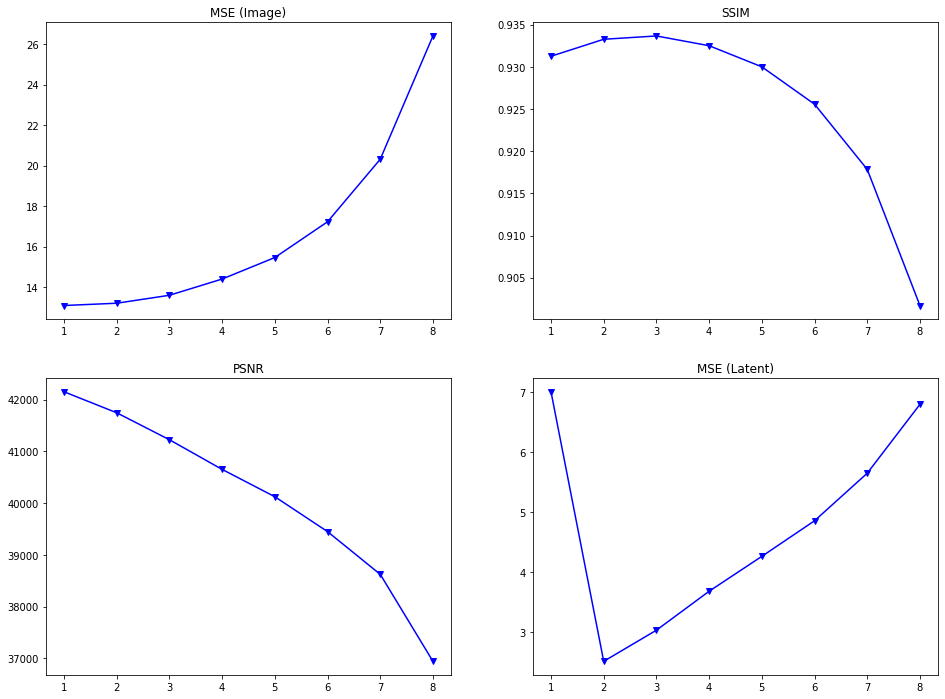

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(16,12))

def add_data_to_plot(name, data):
    properties = name.split("_")
    
    # Map model properties to line properties here
    if "vha" in properties:
        color = "r"
    else:
        color = "b"
        
    if "4step" in properties:
        linestyle = "-."
    else:
        linestyle = "-"
        
    if "nl" in properties:
        marker = "o"
    else:
        marker = "v"
    
    plot_data = {'MSE_x': [], 'SSIM': [], 'PSNR': [], "MSE_z": []}
    for k, v in data.items():
        plot_data['MSE_x'].append(v['MSE_x'])
        plot_data['SSIM'].append(v['SSIM'])
        plot_data['PSNR'].append(v['PSNR'])
        plot_data['MSE_z'].append(v['MSE_z'])

    axs[0,0].plot(
        list(range(1, len(plot_data['MSE_x']) + 1)), 
        plot_data['MSE_x'],
        color=color, 
        linestyle=linestyle,
        marker=marker
    )
    axs[0,1].plot(
        list(range(1, len(plot_data['SSIM']) + 1)), 
        plot_data['SSIM'],
        color=color, 
        linestyle=linestyle,
        marker=marker
    )
    axs[1,0].plot(
        list(range(1, len(plot_data['PSNR']) + 1)), 
        plot_data['PSNR'],
        color=color,
        linestyle=linestyle,
        marker=marker
    )
    axs[1,1].plot(
        list(range(1, len(plot_data['MSE_z']) + 1)), 
        plot_data['MSE_z'],
        color=color,
        linestyle=linestyle,
        marker=marker
    )

axs[0,0].set_title("MSE (Image)")
axs[0,1].set_title("SSIM")
axs[1,0].set_title("PSNR")
axs[1,1].set_title("MSE (Latent)")

for k, v in analysis_data.items():
    add_data_to_plot(k, v)